In [2]:
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import logging
import itertools
import datetime

logger = logging.getLogger('enviroment')

In [3]:
class CarRental:
    def __init__(self, req_mean, ret_mean, startCars):
        self.sell_income = 10.
        self.min_cars = 1
        self.current_cars = startCars
        self.req_mean = req_mean
        self.ret_mean = ret_mean
        
    def nightlyMove(self):
        returned_cars = self.getReturnedCars()
        requested_cars = self.getRequestedCars()
        
        self.addCars(returned_cars - requested_cars)
        
        return requested_cars * self.sell_income
    
    def getCurrentState(self):
        return self.current_cars
    
    def addCars(self, cars):
        if self.current_cars + cars > 20:
            self.current_cars = 20
        else:
            self.current_cars += cars
    
    def getReturnedCars(self):
        return np.random.poisson(self.ret_mean)
        
    def getRequestedCars(self):
        return np.random.poisson(self.req_mean)
    
    def carRentalIsDead(self):
        return self.current_cars < self.min_cars
    
    def s(self, amount):
        self.current_cars += amount
        return self.current_cars
    
    def transact_cars(self, amount):
        self.current_cars += amount

In [4]:
class JacksCarRentalEnvironment: 
    
    def __init__(self):
        self.t = 1
        self.cost_car_exchange = 2.
        self.RENTAL_INCOME = 10
        self.TRANSFER_COST = 2.
        self.done = False
        self.car_rental_a = CarRental(3, 3, np.random.randint(10))
        self.car_rental_b = CarRental(4, 2, np.random.randint(10))
        self.REQUEST_RATE = [3, 4]
        self.RETURN_RATE = [4, 2]
        self.MAX_CAPACITY = 20
    
    def reset(self, numbers = None):
        self.done = False
        self.t = 1
        if numbers == None:
            self.car_rental_a = CarRental(3, 3, np.random.randint(10))
            self.car_rental_b = CarRental(4, 2, np.random.randint(10))
        else:
            self.car_rental_a = CarRental(3, 3, numbers)
            self.car_rental_b = CarRental(4, 2, numbers)
        
        return ([self.car_rental_a.getCurrentState(), self.car_rental_b.getCurrentState()])
        
    def step(self, action):
        reward = 0
        
        self.exchangeCars(action)
        reward -= action * self.cost_car_exchange
        
        if self.car_rental_a.carRentalIsDead() or self.car_rental_b.carRentalIsDead():
            self.done = True
        
        if self.done == False:
            reward += self.car_rental_a.nightlyMove()
            reward += self.car_rental_b.nightlyMove()
        
        self.t += 1
        return ([self.car_rental_a.getCurrentState(), self.car_rental_b.getCurrentState()], reward, self.done, '')
    
    def exchangeCars(self, amount):
        if amount <= 5 and amount >= -5:
            self.car_rental_a.transact_cars(-amount)
            self.car_rental_b.transact_cars(amount)
        elif amount < -5:
            self.car_rental_a.transact_cars(-(-5))
            self.car_rental_b.transact_cars(-5)
        elif amount > 5:
            self.car_rental_a.transact_cars(-5)
            self.car_rental_b.transact_cars(5)
            
        

In [5]:
import unittest

class TestJacksCarRentalEnvironment(unittest.TestCase):
    # there are a lot of magic numbers in this test
    # these numbers depending on the env parameters!
    
    def setUp(self):
        self.env = JacksCarRentalEnvironment()
        
    def _avg_mean(self, cars, action, t_mean, max_diff=1.):
        env = self.env
        n = 10000
        r_mean = 0
        for i in range(n):
            env.reset(cars)
            _, r, _,_ = env.step(action)
            r_mean += r
        r_mean = r_mean / n
        diff = np.abs(r_mean - t_mean)
        self.assertTrue(diff < max_diff)
    
    def test_rent0(self):
        self._avg_mean(20, 0, 70)
        
    def test_rent1(self):
        self._avg_mean(10, 0, 70)    
        
    def test_nightly_moves(self):
        env = self.env
        env.reset(0)
        _, r, _,_ = env.step(5)
        self.assertTrue(r==-10.)
        
    def _avg_nb_cars(self, a_desired, b_desired, 
                     cars, action):
        
        env = self.env
        n = 10000
        a_mean = 0
        b_mean = 0
        for i in range(n):
            env.reset(cars)
            ab, _, _,_ = env.step(action)
            a_mean += ab[0]
            b_mean += ab[1]
        a_diff = np.abs((a_mean / n) - a_desired)
        b_diff = np.abs((b_mean / n) - b_desired)
        self.assertTrue(a_diff < 0.5)
        self.assertTrue(b_diff < 0.5)
    
    def test_nb_cars_10_0(self):
        a_desired = 10
        b_desired = 8 
        cars = 10
        action = 0
        self._avg_nb_cars(a_desired, b_desired, 
                     cars, action)
        
    def test_nb_cars_10_3(self):
        a_desired = 7
        b_desired = 11 
        cars = 10
        action = 3
        self._avg_nb_cars(a_desired, b_desired, 
                     cars, action)
        
    def test_nb_cars_10_m2(self):
        a_desired = 12
        b_desired = 6 
        cars = 10
        action = -2
        self._avg_nb_cars(a_desired, b_desired, 
                     cars, action)
        
unittest.main(argv=['first-arg-is-ignored'], exit=False)

......
----------------------------------------------------------------------
Ran 6 tests in 0.709s

OK


In [6]:
class JacksCarRentalEnvironmentModel(JacksCarRentalEnvironment):
    
    def get_transition_probabilities_and_expected_reward(self, state, action):
        """
            Compute the $p(s', r\mid s,a)$
            Parameters
            ----------
            old_state: tuple of two ints
                the state (cars_at_A, cars_at_B)
            action: int
                nigthly movements of the cars as a int between -5 to 5, e.g.: 
                action +3: move three cars from A to B. 
                action -2: move two cars from B to A.
                
            Returns
            -------
            numpy array (2d - float): mapping from (new) states to probabilities
                index first dimension: cars at A
                index second dimension: cars at B
                value: probability  
            float:  expected reward for the state-action pair
        """
        #assert type(action) == int
        assert np.abs(action) <=5
        # first we move the cars in the night
        num_states_for_a_location = self.MAX_CAPACITY + 1
            
        state = self._nightly_moves(state, action)
    
        expected_reward = - self.TRANSFER_COST * np.abs(action)
        expected_reward += self._expected_reward_rent(state)
        
        transition_probabilities = self._rent_transition_probabilities(state)
        transition_probabilities = self._returns_transition_probabilities(transition_probabilities)
        return transition_probabilities, expected_reward  
        
        
    def _nightly_moves(self, state, action):
        
        cars_at_A = state[0]
        cars_at_B = state[1]
        if action > 0:
            cars_moved = min(action, cars_at_A)
        else:
            cars_moved = max(action, -cars_at_B)
        
        cars_at_A = min(cars_at_A - cars_moved, self.MAX_CAPACITY)
        cars_at_B = min(cars_at_B + cars_moved, self.MAX_CAPACITY)
        return [cars_at_A, cars_at_B]
        
    def _expected_reward_rent(self, state):
        expected_reward_rent = 0.
        m = self.MAX_CAPACITY+1
        request_mu = self.REQUEST_RATE
        for i in (0,1):
            cars_at_loc = state[i]
            rv = scipy.stats.poisson(request_mu[i])
            rent_prob = (rv.pmf(range(m)))
            logger.debug(rent_prob)
            rent_prob[cars_at_loc] = rent_prob[cars_at_loc:].sum()
            rent_prob[cars_at_loc+1:] = 0. 
            logger.debug(rent_prob)
            expected_reward_rent += np.dot(np.arange(len(rent_prob)), rent_prob) * self.RENTAL_INCOME
        return expected_reward_rent
        
    def _rent_transition_probabilities(self, state):
        
        num_states_for_a_location = self.MAX_CAPACITY + 1
        m = 15
        n = num_states_for_a_location + 2*m
        p_  = [np.zeros(n), np.zeros(n)]
        request_mu = self.REQUEST_RATE
        
        for i in (0,1):
            rv = scipy.stats.poisson(request_mu[i])
            cars_at_loc = state[i]
            x = cars_at_loc + m + 1     
            rent_prob = (rv.pmf(range(x)))
            assert state[i]-x+m+1 == 0
            p_[i][0:cars_at_loc+m+1] = rent_prob[::-1]
            p_[i][m] = p_[i][:m+1].sum()
            p_[i] = p_[i][m:-m]
        return p_
    
    def _returns_transition_probabilities(self, state_probalility):
        
        num_states_for_a_location = self.MAX_CAPACITY + 1
        m=11
        n = num_states_for_a_location + 2*m
        returns_mu = self.RETURN_RATE
        p_  = [np.zeros(num_states_for_a_location), np.zeros(num_states_for_a_location)]
        for i in (0,1):
            rv = scipy.stats.poisson(returns_mu[i])
            logger.debug(len(state_probalility[i]))
            for cars_at_loc in range(len(state_probalility[i])):
                p = np.zeros(n)
                logger.debug(p.shape)
                x = num_states_for_a_location - cars_at_loc + m - 1     
                return_prob = (rv.pmf(range(x)))
                logger.debug (p[cars_at_loc+m:-1].shape)
                p[cars_at_loc+m:-1] = return_prob
                logger.debug(return_prob)
                p[num_states_for_a_location+m-1] = p[num_states_for_a_location+m-1:].sum()
                p = p[m:-m]
                logger.debug(p)
                logger.debug(p.sum())
                p_[i] += p * state_probalility[i][cars_at_loc]
        return p_

In [7]:
def plot_policy(policy):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    A, B = np.meshgrid(A, B)
    Po = policy.reshape(MAX_CAPACITY+1,-1)
    levels = range(-5,6,1)
    plt.figure(figsize=(7,6))
    CS = plt.contourf(A, B, Po, levels)
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('actions')
    #plt.clabfrom mpl_toolkits.mplot3d import Axes3D


In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot3d_over_states(f, zlabel="", ):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    # B, A !!!
    B, A = np.meshgrid(B, A)
    V = f.reshape(MAX_CAPACITY+1,-1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax = fig.gca(projection='3d')
    #surf = ax.plot_surface(A, B, V, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                   linewidth=0, antialiased=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.scatter(A, B, V, c='b', marker='.')
    ax.set_xlabel("cars at A")
    ax.set_ylabel("cars at B")
    ax.set_zlabel(zlabel)
 
    #ax.view_init(elev=10., azim=10)
    
    plt.show()

In [9]:
"""
1. Initialization 
    Value for State  Policy for State 
    V (s) ∈ R and π(s) ∈ A(s) arbitrarily for all s ∈ S

2. Policy Evaluation
    Repeat
        ∆ ← 0
        For each s ∈ S:
            v ← V (s)
            V (s) ← Bellman Eq.
            ∆ ← max(∆, |v − V (s)|)
    until ∆ < θ (a small positive number)

3. Policy Improvement
    policy-stable ← true
    For each s ∈ S:
        old-action ← π(s)
        π(s) ← ArgMax Bellman Eq.
        If old-action != π(s), then policy-stable ← f alse
    If policy-stable, then stop and return V ≈ v∗ and π ≈ π∗; else go to 2
"""

# all possible states
states = []
for i in range(0, 20 + 1):
    for j in range(0, 20 + 1):
        states.append([i, j])


def oneStepAhead(transition_probabilities, reward, Vs):
    return np.sum(np.outer(transition_probabilities[0], transition_probabilities[1]) * (reward + 0.9 * Vs))


def policyImprovement(Vs, policy, env):
    while True:
        # Will be set to false if we make any changes to the policy
        improvePolicy = True
        newPolicy = np.zeros((21, 21), dtype=np.int)
        actions = np.arange(-5, 6)

        for s1, s2 in states:
            action_returns = []
            for action in actions:
                (probabilities, reward) = env.get_transition_probabilities_and_expected_reward((s1, s2), action)
                action_returns.append(oneStepAhead(probabilities, reward, Vs))
            newPolicy[s1, s2] = actions[np.argmax(action_returns)]

        # if policy is stable
        policyChanges = np.sum(newPolicy != policy)
        print('Policy for', policyChanges, 'states changed')
        print("Policy: ", newPolicy)
        return newPolicy


def policyEvaluation(Vs, policy, env):
    while True:
        v = np.zeros((21, 21))
        for a, b in states:
            (trans_probs, reward) = env.get_transition_probabilities_and_expected_reward((a, b), policy[a][b])
            v[a][b] = oneStepAhead(trans_probs, reward, Vs)
        # print("delta: ", np.sum(np.abs(v - Vs)))
        if np.allclose(v, Vs):
            # print('Values: ', Vs)
            Vs = v
            return v
        else:
            Vs = v


def policyIteration(iterations=15, env=JacksCarRentalEnvironmentModel()):
    Vs = np.zeros((21, 21))
    policy = np.zeros((21, 21), dtype=np.int)

    for i in range(iterations):
        Vs = policyEvaluation(Vs, policy, env)
        policy = policyImprovement(Vs, policy, env)

    return (policy, Vs)


def valIteration(env=JacksCarRentalEnvironmentModel()):
    V_old = np.ones((21, 21)) / 0.9
    V = np.ones((21, 21)) / 0.9
    policy_old = np.zeros((21, 21), dtype=np.int)
    policy = np.zeros((21, 21), dtype=np.int)
    actions = np.arange(-5, 6)

    converged = False
    iteration = 1

    while not converged:
        start = datetime.datetime.now()
        for a, b in states:
            (trans_probs, reward) = env.get_transition_probabilities_and_expected_reward((a, b), policy[a][b])
            V[a][b] = oneStepAhead(trans_probs, reward, V_old)

        for s1, s2 in states:
            action_returns = []
            for action in actions:
                (probabilities, reward) = env.get_transition_probabilities_and_expected_reward((s1, s2), action)
                action_returns.append(oneStepAhead(probabilities, reward, V))
            policy[s1, s2] = actions[np.argmax(action_returns)]

        if np.allclose(policy, policy_old):
            converged = True
        print("time elapsed: ",(datetime.datetime.now() - start))
        print("time estimated for 50: ",(datetime.datetime.now() - start) * (50-iteration))
        print("iteration: ", iteration, " Difference V: ", np.max(np.abs(V - V_old)), " Difference P: ", np.allclose(policy, policy_old))
        V_old = V.copy()
        policy_old = policy.copy()
        iteration += 1

    return policy, V

In [17]:
(policy, V) = valIteration()

time elapsed:  0:00:49.778486
time estimated for 50:  0:40:39.152625
iteration:  1  Difference V:  69.8888715818  Difference P:  False
time elapsed:  0:00:52.043555
time estimated for 50:  0:41:38.097408
iteration:  2  Difference V:  79.5034728299  Difference P:  False
time elapsed:  0:00:55.401379
time estimated for 50:  0:43:23.869654
iteration:  3  Difference V:  56.5734788232  Difference P:  False
time elapsed:  0:00:54.989935
time estimated for 50:  0:42:09.542530
iteration:  4  Difference V:  50.7134574792  Difference P:  False
time elapsed:  0:00:55.889230
time estimated for 50:  0:41:55.022955
iteration:  5  Difference V:  45.1971877874  Difference P:  False
time elapsed:  0:00:52.444175
time estimated for 50:  0:38:27.564204
iteration:  6  Difference V:  40.1685290312  Difference P:  False
time elapsed:  0:00:51.705195
time estimated for 50:  0:37:03.329921
iteration:  7  Difference V:  35.7227651408  Difference P:  False
time elapsed:  0:00:51.374701
time estimated for 50:  0

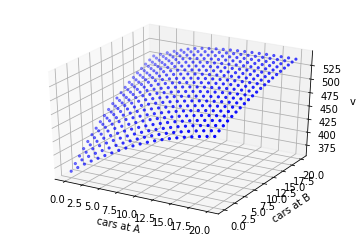

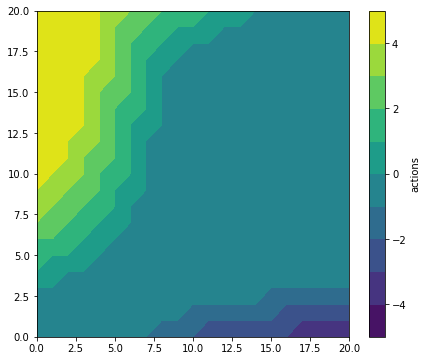

In [18]:
plot3d_over_states(V, 'v')
plot_policy(policy)

In [10]:
(pol_policy, pol_V) = policyIteration()

Policy for 349 states changed
Policy:  [[ 0  0  0  0  0  0  0  0 -1 -1 -1 -1 -2 -2 -2 -2 -2 -2 -3 -3 -3]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -2 -2 -2 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1]
 [ 1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  2  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3  2  2  2  2  2  1  1  1  1  1  1  0  0  0  0  0  0  0  0]
 [ 4  3  3  3  3  3  2  2  2  2  2  2  1  1  1  1  1  0  0  0  0]
 [ 4  4  4  4  4  3  3  3  3  3  3  2  2  2  2  2  1  1  1  0  0]
 [ 5  5  5  5  4  4  4  4  4  4  3  3  3  3  3  2  2  2  1  1  0]
 [ 5  5  5  5  5  5  5  5  5  4  4  4  4  4  3  3  3  2  2  1  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  5  5  4  4  4  3  3  2  1  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  4  4  3  2  1  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  4  3  2  1  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  4  3  2  1  0]
 [ 5  5  5  5  5  5  5  5  5  5  5  5

Policy for 0 states changed
Policy:  [[ 0  0  0  0  0  0  0 -1 -1 -2 -2 -2 -3 -3 -3 -3 -3 -3 -4 -4 -4]
 [ 0  0  0  0  0  0  0  0 -1 -1 -1 -2 -2 -2 -2 -2 -2 -3 -3 -3 -3]
 [ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -2 -2 -2 -2 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1]
 [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  3  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  3  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  4  4  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  3  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  4  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  4  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  4  3  2  2  1  0  0  0  0  

Policy for 0 states changed
Policy:  [[ 0  0  0  0  0  0  0 -1 -1 -2 -2 -2 -3 -3 -3 -3 -3 -3 -4 -4 -4]
 [ 0  0  0  0  0  0  0  0 -1 -1 -1 -2 -2 -2 -2 -2 -2 -3 -3 -3 -3]
 [ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -2 -2 -2 -2 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1]
 [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  3  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  3  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  4  4  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  3  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  4  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  4  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  4  3  2  2  1  0  0  0  0  

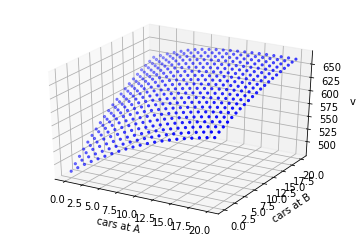

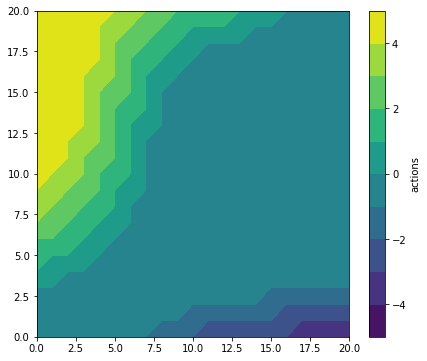

In [12]:
plot3d_over_states(pol_V, 'v')
plot_policy(pol_policy)

In [31]:
def getStateIndex(carA, carB):
    return (carA * 21) + carB

In [34]:
start = datetime.datetime.now()
nb_states = 441
nb_actions = 11
env = JacksCarRentalEnvironmentModel()
gamma = 0.9

actions = np.arange(-5,6)
R_SA = np.zeros((nb_states, nb_actions))
P_SAS_prime = np.zeros((nb_states, nb_actions, nb_states))

for i,j in states:
    for index in range(len(actions)):
        (transition_probabilities, expected_reward) = env.get_transition_probabilities_and_expected_reward((i,j), actions[index])
        R_SA[getStateIndex(i,j)][index] = expected_reward
        all_probabilities = np.outer(transition_probabilities[0], transition_probabilities[1]).flatten()
        P_SAS_prime[getStateIndex(i,j)][index] = all_probabilities

In [35]:
def value_iteration_q(gamma = 0.9, 
                      expected_reward=R_SA,
                        P_s_prime = P_SAS_prime, 
                        Q=np.zeros((nb_states, nb_actions))):
    
    """Policy Evaluation by Policy Iteration for Q"""
    converged = False
    while not converged:
        V_max = np.max(Q, axis=1)
        new_Q = expected_reward + gamma * np.dot(P_s_prime, V_max)
        if np.allclose(new_Q, Q):
            converged = True
        Q = new_Q
    return Q

In [36]:
Q = value_iteration_q(0.9, R_SA, P_SAS_prime)
print("time used: ", datetime.datetime.now() - start)

time used:  0:00:44.585963


In [37]:
pi = np.argmax(Q[:, 1:], axis=1)

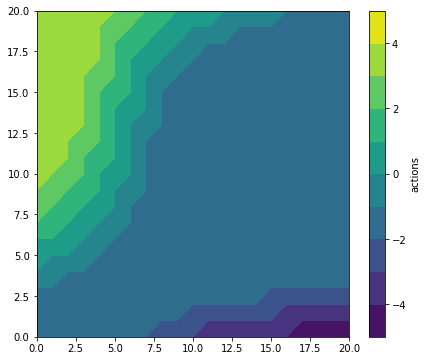

In [38]:
plot_policy(pi-5)